In [1]:
%pip install import tensorflow as tf
%pip install timm

ERROR: Could not find a version that satisfies the requirement import (from versions: none)
ERROR: No matching distribution found for import
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install tensorflow
%pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
response = requests.get(url, stream=True)

if response.status_code == 200:
    with open('images.tar', 'wb') as file:
        file.write(response.content)
else:
    print(f'Failed to download file, status code: {response.status_code}')


KeyboardInterrupt: 

In [16]:
import tarfile

with tarfile.open('images.tar') as tar:
    tar.extractall()

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset_path = './Images'
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the model path
model_path = "resnet50_trained.pth"
#model_path = '/content/gdrive/My Drive/resnet50_trained.onnx'
# Load the trained model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# Assuming 'dataset' is your ImageFolder dataset
class_to_idx = dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(input_image: Image):
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    # # Assuming 'dataset' is your ImageFolder dataset
    # class_to_idx = dataset.class_to_idx
    # idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

    return idx_to_class[predicted_idx.item()]

print(class_to_idx)
print(idx_to_class)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

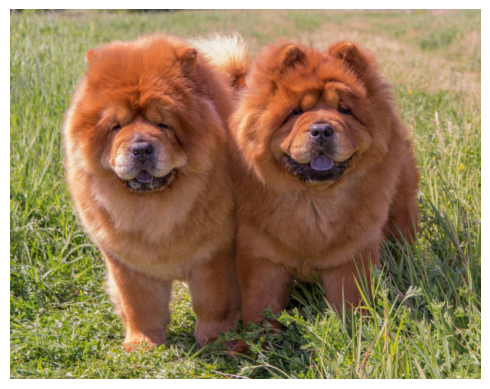

The predicted class of the test image is: chow


In [6]:
# Test Case 1
from PIL import Image
import matplotlib.pyplot as plt

test_image_path = "Img_1.jpg"
test_image = Image.open(test_image_path)

# Show the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

# Run prediction function on the test image
predicted_class = predict(test_image)
class_idx, class_name = predicted_class.split("-")
class_name = class_name.replace("_", " ")
print(f"The predicted class of the test image is: {class_name}")


In [ ]:
%pip install flask-ngrok


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade flask-ngrok


In [17]:
import os
import json
from flask import Flask, request, jsonify, render_template
from PIL import Image
import torch
from torchvision import transforms, datasets

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset_path = os.path.join(".", "Images")
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Map classes to indices
class_to_idx = dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

In [18]:
import os
import json
from flask import Flask, request, jsonify, render_template
from PIL import Image
import torch
from torchvision import transforms, datasets

# Define the Flask app
app = Flask(__name__)

# Define the model path
model_path = os.path.join(".", "resnet50_trained.pth")

# Load the trained model
model = torch.load(model_path, map_location='cpu')
model.eval()  # Set the model to evaluation mode

# # Define the transformation
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Load the dataset
# dataset_path = os.path.join(".", "Images")
# dataset = datasets.ImageFolder(dataset_path, transform=transform)

# # Map classes to indices
# class_to_idx = dataset.class_to_idx
# idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        file = request.files.get('image')
        if file is None:
            return jsonify({'error': 'no file'}), 400

        image = Image.open(file.stream)
        image = transform(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            output = model(image)

        _, predicted_idx = torch.max(output, 1)
        predicted_class = idx_to_class[predicted_idx.item()]
        class_idx, class_name = predicted_class.split("-")
        class_name = class_name.replace("_", " ")

        return jsonify({'predicted_class': class_name})

    else:
        return render_template('index.html')

# Run the Flask application
if __name__ == '__main__':
    app.run(port=8080)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
[2023-07-14 09:03:53,015] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/jbaca/opt/anaconda3/lib/python3.9/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_